<a href="https://colab.research.google.com/github/Insight-Sogang-Univ/CaptionTeam/blob/main/ImageEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil
shutil.rmtree('/content/drive/My Drive/repos/CaptionTeam')

%cd /content/drive/MyDrive/repos
!git clone https://github.com/Insight-Sogang-Univ/CaptionTeam
%cd CaptionTeam

FOLDERNAME = '/content/drive/My Drive/repos/CaptionTeam/'
IMG_FOLDER = '/content/drive/My Drive/img'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('{}'.format(FOLDERNAME))

/content/drive/MyDrive/repos
Cloning into 'CaptionTeam'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 99 (delta 37), reused 74 (delta 20), pack-reused 0
Unpacking objects: 100% (99/99), done.
/content/drive/MyDrive/repos/CaptionTeam


In [76]:
import torch
from PIL import Image
from torchvision import transforms

preprocess = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()
feature_extractor = torch.nn.Sequential(*list(model.children())[:-2])
feature_extractor.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, moment

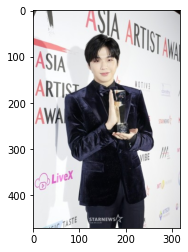

In [83]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
import pandas as pd

captions = pd.read_csv('captions.csv')
img_dir = IMG_FOLDER
idx=0
img_path = os.path.join(img_dir, captions.loc[idx, 'head'], captions.loc[idx, 'name'])
img = read_image(img_path)
plt.imshow(np.transpose(img,(1,2,0)))
plt.show()

In [85]:
import os
from image_encoder.dataset import CelebDataset
from torch.utils.data import DataLoader

dataset = CelebDataset(os.path.join(FOLDERNAME,'captions.csv'), IMG_FOLDER, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [112]:
import torch.nn as nn
import torchvision.models as models

class EncoderInception3(nn.Module):
  def __init__(self, output_size, train=False):
    super(EncoderInception3, self).__init__()
    self.train = train
    self.inception = models.inception_v3(pretrained=True, aux_logits=False)
    self.inception.fc = nn.Linear(self.inception.fc.in_features, output_size)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout()

  def forward(self, images):
    features = self.inception(images)

    for name, param in self.inception.named_parameters():
      if 'fc.weight' in name or 'fc.bias' in name:
        param.requires_grad = True
      else :
        param.requires_grad = self.train

    return self.dropout(self.relu(features))

In [113]:
#from image_encoder.encoder import EncoderInception3
feature_extractor = EncoderInception3(2048)

In [114]:
import numpy as np

for image, label in dataloader:
  print(image.size())
  with torch.no_grad():
    # result = model(image)
    result = feature_extractor(image)
  break
print(result)

torch.Size([2, 3, 299, 299])
